In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Paths
base_dir = '/content/drive/MyDrive/***DataSet_Thesis2024/new2024_3_Sobel'  # Replace with your dataset folder in Google Drive
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
model_save_path = '/content/drive/MyDrive/***DataSet_Thesis2024/new2024_1/modeloutput/efficentnetB7/30_R1_Sobel_epoch_efficientnetb7_clean_vs_unclean.pth'  # Replace with desired save path

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_CLASSES = 2
EPOCHS = 30
LEARNING_RATE = 0.001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
DEVICE

'cuda'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 233MB/s]


Epoch 1/30
--------------------
Train Loss: 0.2240 Acc: 0.9281
Val Loss: 0.6046 Acc: 0.5663
Epoch 2/30
--------------------
Train Loss: 0.0604 Acc: 0.9850
Val Loss: 0.0692 Acc: 0.9825
Epoch 3/30
--------------------
Train Loss: 0.0292 Acc: 0.9894
Val Loss: 0.0139 Acc: 0.9981
Epoch 4/30
--------------------
Train Loss: 0.0405 Acc: 0.9869
Val Loss: 0.0116 Acc: 0.9969
Epoch 5/30
--------------------
Train Loss: 0.0318 Acc: 0.9888
Val Loss: 0.3367 Acc: 0.9081
Epoch 6/30
--------------------
Train Loss: 0.0297 Acc: 0.9906
Val Loss: 0.0143 Acc: 0.9969
Epoch 7/30
--------------------
Train Loss: 0.0030 Acc: 0.9994
Val Loss: 0.0095 Acc: 0.9962
Epoch 8/30
--------------------
Train Loss: 0.0244 Acc: 0.9956
Val Loss: 0.0282 Acc: 0.9925
Epoch 9/30
--------------------
Train Loss: 0.0289 Acc: 0.9931
Val Loss: 0.1188 Acc: 0.9581
Epoch 10/30
--------------------
Train Loss: 0.0214 Acc: 0.9950
Val Loss: 0.2670 Acc: 0.9306
Epoch 11/30
--------------------
Train Loss: 0.0096 Acc: 0.9969
Val Loss: 0.007

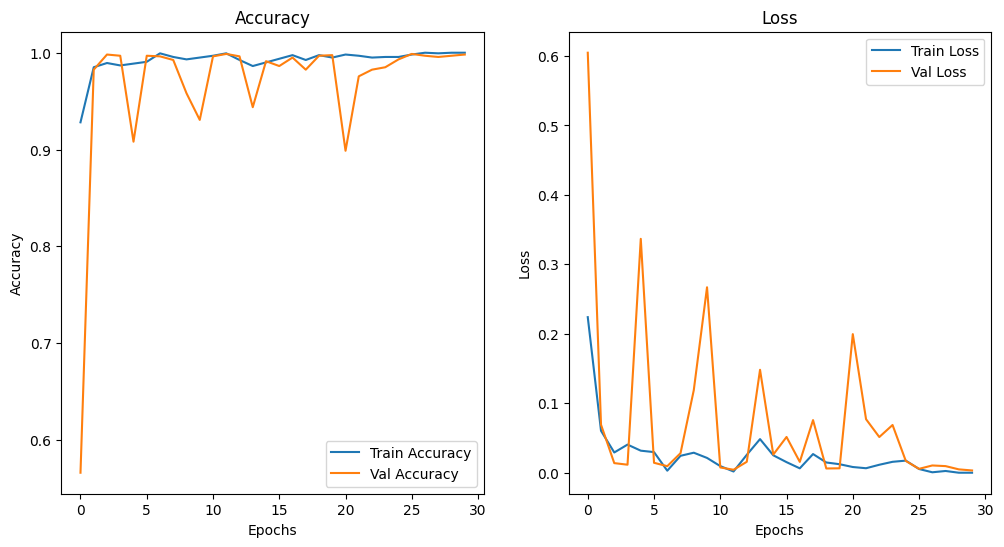

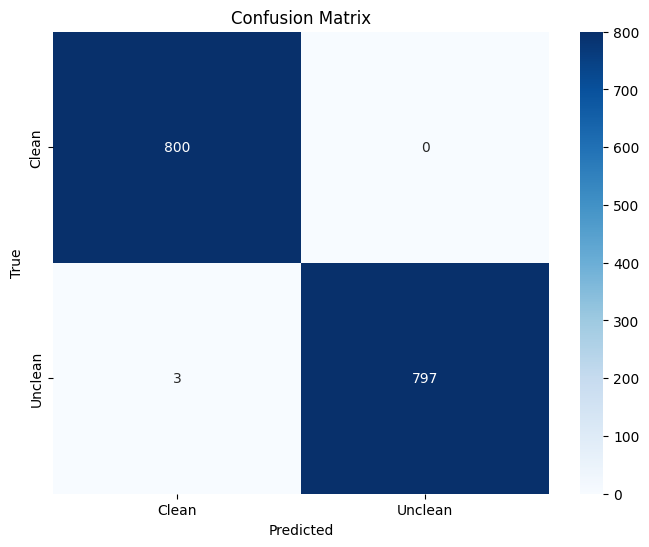

Classification Report:

              precision    recall  f1-score   support

       Clean   0.996264  1.000000  0.998129       800
     Unclean   1.000000  0.996250  0.998121       800

    accuracy                       0.998125      1600
   macro avg   0.998132  0.998125  0.998125      1600
weighted avg   0.998132  0.998125  0.998125      1600

Model saved successfully to /content/drive/MyDrive/***DataSet_Thesis2024/new2024_1/modeloutput/efficentnetB7/30_R1_Sobel_epoch_efficientnetb7_clean_vs_unclean.pth


In [5]:
# Data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Datasets and DataLoaders
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model: EfficientNetB7
model = models.efficientnet_b7(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Linear(128, NUM_CLASSES)
)
model = model.to(DEVICE)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 20)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc.item())

        print(f"Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Save the best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model, history

# Train the model
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

# Plot accuracy and loss graphs
def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

# Evaluate the model on the validation set
model.eval()
all_preds = []
all_labels = []
for inputs, labels in val_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes,digits=6))

# Save the model
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f"Model saved successfully to {model_save_path}")
